: '
================================================================================
Pipeline: Single-cell RNA-seq Preprocessing, QC, Integration, and Export
Purpose: Prepare a high-quality single-cell reference for Cell2location

Description:
    This script implements preprocessing, quality control (QC), integration, 
    and export of single-cell RNA-seq reference data prior to spatial 
    deconvolution with Cell2location.

Environment Setup:
    # Local setup with conda/mamba
    mamba activate cell2loc_prep_r
    mamba install ipykernel
    python3 -m ipykernel install --user --name=cell2loc_prep_r --display-name "cell2loc_prep_r"

    # Register R kernel
    R
    install.packages("IRkernel")
    IRkernel::installspec(user = TRUE)
    quit()

Input Data:
    - GEO accession: GSE158937
      Single-cell RNA sequencing samples from high-grade serous ovarian cancer.
    - Files per sample (10x Genomics format):
        barcodes.tsv   : Unique cell identifiers
        features.tsv   : List of measured genes
        matrix.mtx     : Sparse gene expression matrix

    - Example samples used:
        GSM4816045, GSM4816046, GSM4816047

Workflow Steps:
    1. Load raw 10x data into Seurat objects.
    2. Perform QC:
         - Keep cells with >200 and <7500 detected genes.
         - Exclude cells with >10% mitochondrial gene content.
    3. Normalize data and identify 2000 highly variable genes.
    4. Integrate samples:
         - Select common features.
         - Find anchors (matched cells across datasets).
         - Correct batch effects and merge datasets.
    5. (Optional) Scale, PCA, UMAP, clustering for QC visualization.
    6. Export integrated object to:
         - H5Seurat format (.h5Seurat).
         - H5AD format (.h5ad) for Python/Scanpy compatibility.

Outputs:
    - QC violin plots per sample (genes, UMIs, mitochondrial %).
    - Integrated Seurat object.
    - Exported files:
        comb_GSE158937.h5Seurat
        comb_GSE158937.h5ad

Notes:
    - Mitochondrial genes are retained in Visium workflows, but here we filter 
      high-mito cells to build a clean reference for Cell2location.
    - UMAP and PCA checks ensure successful batch integration.

================================================================================
'


In [ ]:
#if local 
mamba activate cell2loc_prep_r
#mamba install ipykernel
#python3 -m ipykernel install --user --name=cell2loc_prep_r --display-name "cell2loc_prep_r"

In [ ]:
#register kernel 
#in terminal, open R
#install.packages('IRkernel')
#IRkernel::installspec(user = TRUE)
#quit()
.libPaths()
ip <- installed.packages(fields = "LibPath")
ip


pipeline for single cell preprocessing, QC, integration and export prior to cell2location  
Single cell reference data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE158937 	Single-cell RNA sequencing samples from high-grade serous ovarian cancer (HGSOC)  
    barcodes.tsv: List of all cell barcodes (unique cell IDs)  
    features.tsv or genes.tsv: List of all genes/features measured (gene names or IDs)  
    matrix.mtx: The raw count matrix itself, in sparse format, matching barcodes x feature   

NOTE need to also compare with https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE266577  
which I can load and filter to ovary and treatment naive samples and then use the pre-annotated cell types - scroll down to bottom to see this

In [1]:
library(Seurat)
library(SeuratDisk)
library(dplyr)
library(scCATCH)


data_dir <- "/home/lythgo02/Documents/scRNAseq/GSE158937_RAW"
samples <- c("GSM4816045", "GSM4816046", "GSM4816047")  # replace with your sample IDs
seurat_list <- lapply(samples, function(samp) {
  folder <- file.path(data_dir, paste0(samp, "_filtered"))
  counts <- Read10X(data.dir = folder)
  seu <- CreateSeuratObject(counts = counts, 
                            project = samp, 
                            min.cells = 3, #only genes expresssed in at least 3 cells
                            min.features = 200) # only cells with at least 200 genes detected to remove low quality cells 
  seu$orig.ident <- samp
  return(seu)
})

names(seurat_list) <- samples




Attaching SeuratObject

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




QC on each sample 
    Mitochondrial content - keep cells where the % expressed genes that are mitochdondrial is <10% (high damage = cells that leak mitochondrial RNA)
     - (Building a reference for deconvolution so want clean, well-annotated cell types to form accurate basis profiles. 
     - Removing low-quality or stressed cells even though i have retained mitochondrial genes in the visium QC).
     - Remove cells with fewer than 200 genes detected
     - Remove cells with more than 7500 genes detected 
        (Abnormally high numbers of genes detected indicates doublets or multiplets captured in cell capture)    


In [ ]:

library(ggplot2)

#plot directory 
qc_plot_dir<- "/home/lythgo02/Documents/scRNAseq/plots/"

# Apply QC step-by-step and name plots correctly
seurat_list <- lapply(names(seurat_list), function(sample_name) {
  seu <- seurat_list[[sample_name]]
  
  # Add mitochondrial gene percentage
  seu[["percent.mt"]] <- PercentageFeatureSet(seu, pattern = "^MT-")
  
  # Create and save QC violin plot
  #qc_plot <- VlnPlot(seu, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
  #ggsave(
  #  filename = file.path(qc_plot_dir, paste0(sample_name, "_qc_violin.png")),
  #  plot = qc_plot,
  #  width = 10,
  #  height = 4
  #)

  # Filter cells
  seu <- subset(seu, subset = nFeature_RNA > 200 & nFeature_RNA < 7500 & percent.mt < 10)
  
  return(seu)
})

# Restore names
names(seurat_list) <- c("GSM4816045", "GSM4816046", "GSM4816047")



In [ ]:

Interpretation ofo violin plots:
    nFeature_RNA (number of genes per cell): Most cells have 200–1000 genes detected: some outliers at higher end but acceptable 
    nCount_RNA (total UMIs per cell): Skewed distribution with a long tail —  few cells with very high RNA content (>20,000 UMIs). Might suggest doublets or highly active cells.
    percent.mt (mitochondrial gene percentage): Evenly distributed from ~0 to 10%, with many cells around 2–8%. This is expected; <10% is usually considered acceptable.

Suitable filters applied.

Normalise
Find highly variable genes 

In [ ]:
seurat_list <- lapply(seurat_list, function(seu) {
  seu <- NormalizeData(seu)    #log normalisation
  seu <- FindVariableFeatures(seu, 
                              selection.method = "vst", #variant stabilising transformation to find top 2000 variable genes
                              nfeatures = 2000)   
  return(seu) 
})


Integrate samples based on shared genes  
Find "anchors," pairs of cells from different datasets that are in a matched biological state using dimensionality reduction. 
Use the anchors to correct batch effects and merge datasets into a single integrated Seurat object 

 - SelectIntegrationFeatures() → picked common genes across samples.
 - FindIntegrationAnchors() → matched biologically similar cells across datasets.
 - IntegrateData() → corrected batch effects.

In [ ]:
# Select features (common genes) for integration
features <- SelectIntegrationFeatures(object.list = seurat_list) #output = vector of gene names for integration 

# Find integration anchors (using PCA)
anchors <- FindIntegrationAnchors(object.list = seurat_list, anchor.features = features)

# Integrate data
seu_integrated <- IntegrateData(anchorset = anchors)

# Switch to integrated assay for downstream analysis
DefaultAssay(seu_integrated) <- "integrated"

Scaling, PCA, clustering, UMAP  
 - Scale and centre the gene expression values by dividing by standard deviation and subtracting the gene's mean, each gene becomes mean 0, variance 1
 - Perform dimensionality reduction and clustering then plot to check for batch effects


In [ ]:


seu_integrated <- ScaleData(seu_integrated, verbose = FALSE)
seu_integrated <- RunPCA(seu_integrated, npcs = 50, verbose = FALSE)

#explore PCA
e <- ElbowPlot(seu_integrated, ndims=50)

ggsave(
    filename = file.path(qc_plot_dir, "elbow_plot_pca.png"),
    plot = e,
    width = 10,
    height = 4
  )

seu_integrated <- RunUMAP(seu_integrated, reduction = "pca", dims = 1:20)


In [ ]:

#check origin 
table(seu_integrated$orig.ident)

#plot umap coloured by sample
p_pca <- DimPlot(seu_integrated, reduction = "pca", group.by = "orig.ident") +
  ggtitle("pca coloured by sample")

ggsave(filename = file.path(qc_plot_dir, "pca_by_sample.png"), 
plot = p_pca, width = 6, height = 5, dpi = 300)

p_umap <- DimPlot(seu_integrated, reduction = "umap", group.by = "orig.ident") +
  ggtitle("umap coloured by sample")

ggsave(filename = file.path(qc_plot_dir, "umap_by_sample.png"),
 plot = p_umap, width = 6, height = 5, dpi = 300)

In [ ]:
DimPlot(seu_integrated, label=TRUE)




This UMAP suggests:
 - Well mixed clusters, no dominant sample specific regions suggesting successful integration and correction of batch effects.
 - Cells are grouped primarily by biological similarity, not by sample origin.
Downstream steps: clustering, cell type annotation, differential expression, etc.

In [ ]:
#gene markers for broad cell type classification 
marker_sets <- list(
  Epithelial_Tumour = c(
    "EPCAM","KRT8","KRT18", "KRT19","MUC1",   # epithelial markers
    "WFDC2","PAX8", "WT1", "MUC16"            # tumour markers
  ),
  Tcell = c("CD3D", "CD3E", "CD3G", "TRAC", "CD2", "CD4", "CD8A", "CD8B"),

  Bcell = c("CD19", "MS4A1", "CD79A"),
  
  #NKcell = c("KLRD1", "KLRF1", "NCR1", "TYROBP"),  # Specific to NK

  Myeloid = c("LYZ", "C1QA", "C1QB", "C1QC", "CD68", "CD14", "CD163", "ITGAM", "CSF1R"),
  
  Endo = c("PECAM1", "VWF", "CLDN5", "CDH5"),
  
  Stromal = c("CFD", "C7", "DPT", "CCN5", "DCN", "COL1A1", "COL1A2", "PDGFRA", "FAP", "PDGFRB", "RGS5", "CSPG4", "MYH11", "ACTA2", "TAGLN", "CNN1")
)





In [ ]:
# Find neighbors based on PCA
seu_integrated <- FindNeighbors(seu_integrated, dims = 1:20)


Run loop to test each resolution for identification of broad cell lineages

In [ ]:

# Define resolutions
# Define resolutions
resolutions <- c(1.2)
# Initialize plot lists
umap_raw_plots <- list()
umap_annotated_plots <- list()
heatmap_plots <- list()

for (res in resolutions) {
  message("Processing resolution: ", res)
  
  # Work on a copy to keep seu_integrated unchanged
  seu_copy <- FindClusters(seu_integrated, resolution = res)
  
  # UMAP with raw cluster IDs
  p1 <- DimPlot(seu_copy, reduction = "umap", label = TRUE) + 
    ggtitle(paste("Resolution", res))
  umap_raw_plots[[as.character(res)]] <- p1  #assign to list

  #ggsave(filename = file.path(qc_plot_dir, paste0("UMAP_clusters_res", res, ".pdf")),plot = p1, width = 7, height = 6)
  
  # Find markers
  seu_markers <- FindAllMarkers(seu_copy, only.pos = TRUE)
  
  # Annotate clusters by most overlapping marker set
  cluster_ids <- levels(Idents(seu_copy))
  cluster_annotations <- sapply(cluster_ids, function(cl) {
    cluster_genes <- seu_markers %>% filter(cluster == cl) %>% pull(gene)
    proportions <- sapply(marker_sets, function(cell_type){
                          length(intersect(cluster_genes, cell_type))/length(cell_type)
    })
    names(which.max(proportions))
  })
  names(cluster_annotations) <- cluster_ids
  
  # Rename cluster identities
  seu_copy <- RenameIdents(seu_copy, cluster_annotations)
  
  # UMAP with annotated cluster IDs
  p2 <- DimPlot(seu_copy, reduction = "umap", label = TRUE, pt.size = 0.5) + 
    ggtitle(paste("Annotated clusters - res", res))
  
  umap_annotated_plots[[as.character(res)]] <- p2 #assign to list

  #ggsave(filename = file.path(qc_plot_dir, paste0("UMAP_annotated_res", res, ".pdf")),plot = p2, width = 7, height = 6)
  
  # Top 10 markers per cluster
  top10 <- seu_markers %>%
    group_by(cluster) %>%
    filter(avg_log2FC > 1) %>%
    slice_head(n = 10) %>%
    ungroup()
  
  feats <- unique(top10$gene)
  p3 <- DoHeatmap(seu_copy, features = feats, raster = TRUE) + NoLegend() +
    ggtitle(paste("Top10 Markers - res", res))
  
  heatmap_plots[[as.character(res)]] <- p3
  
  #ggsave(filename = file.path(qc_plot_dir, paste0("heatmap_res", res, ".pdf")),plot = p3, width = 7, height = 6)
}




Display plots from previous chunk

In [ ]:
combined_umap <- patchwork::wrap_plots(umap_annotated_plots, ncol=2)
combined_heatmap <- patchwork::wrap_plots(heatmap_plots, ncol=2)
options(repr.plot.width=16, repr.plot.height=16)
combined_umap
combined_heatmap

At resolution of 1.2:
 - umap raw - 18 well separated clusters
 - umap annotated - collapsed into 8 major types 
 - heatmap - confirms good separation of major lineages with ability to separate bigger compartments (tumour, myeloid and T-cells further)  

Run chosen resolution to identify clusters (stored in Idents(seu_integrated))  
Then run FindAllMarkers which identifies DEGs between clusters and returns a dataframe with:
 - gene
 - cluster
 - avg_log2FC
 - pct.1
 - pct.2
 - p_val
 - p_val_adj  
Where each row is a marker gene for a particular cluster 

In [ ]:
#run with chosen resolution for broad lineages
seu_integrated <- FindClusters(seu_integrated, resolution = 1.2)
#find markers
seu_markers <- FindAllMarkers(seu_integrated, only.pos = TRUE)


In [ ]:
head(seu_markers)

In [ ]:
# Ensure you're using the same object
cluster_ids <- levels(Idents(seu_integrated))

# Get annotation per cluster based on marker proportions
cluster_annotations <- sapply(cluster_ids, function(cl) {
    cluster_genes <- seu_markers %>% filter(cluster == cl) %>% pull(gene)
    proportions <- sapply(marker_sets, function(cell_type){
        length(intersect(cluster_genes, cell_type)) / length(cell_type)
    })
    if (max(proportions) == 0) {
        return("Other")
    } else {
        return(names(which.max(proportions)))
    }
})

# Rename cluster identities
names(cluster_annotations) <- cluster_ids
seu_integrated <- RenameIdents(seu_integrated, cluster_annotations)

# Store annotations
seu_integrated$lineage <- Idents(seu_integrated)
seu_integrated$subtypes <- Idents(seu_integrated)

# Subset by broad lineage
tcell_subset <- subset(seu_integrated, idents = "Tcell")
myeloid_subset <- subset(seu_integrated, idents = "Myeloid")
stromal_subset <- subset(seu_integrated, idents = "Stromal")


In [147]:
#marker sets for reclustering
stromal <- list(
  # Stromal
  myCAFs     = c("POSTN","VCAN","COL10A1","COL11A1","MMP11", "ACTA2", "FAP"), # inflammatory and high in HRD tumours
  indolent_CAFs      = c("ADH1B","PROK1","CCN5"), #indolent CAFs. high in HRP
  inflammatory_CAFs      = c("C7","CFD","DPT"),
  Mesofibs = c("KRT8","KRT19","SNAI1", "VEGFA"),  #inflammatory and high in HRD tumours
  Pericytes = c("RGS5","PDGFRB","CSPG4"),
  SMC =c("MYH11","ACTA2","TAGLN","CNN1"))


myeloid <- list(
  Macrophages_M1 = c("IL1B", "TNF", "CXCL9", "CXCL10", "NOS2"),
  Macrophages_M2 = c("CD163", "MRC1", "TGFB1", "STAB1", "MSR1", "CD206"),
  Dendritic_cells = c("CD1C", "CLEC9A", "LAMP3", "BATF3", "IRF8"),
  Neutrophils = c("S100A8", "S100A9", "CXCR2", "FCGR3B", "CXCR1"),
  Mast_cells = c("KIT", "TPSAB1", "CPA3", "MS4A2"),
  MDSCs = c("ARG1", "CD33", "ITGAM", "OLR1", "S100A9")
)

t_cells <- list(
  # T cells (subsets)
  CD8_proliferating_T_cell = c("CD8A", "TOP2A", "MKI67"),
  CD8_naive_T_cell = c("CD8A", "CCR7", "SELL", "TCF7"),
  CD8_memory_T_cell    = c("CD8A","GPR183","IL7R"),
  CD8_exhausted_T_cell   = c("CD8A","PDCD1","CTLA4","TIGIT","HAVCR2","TOX"),
  CD8_cytotoxic_T_cell   = c("CD8A","GZMB","GNLY","PRF1","NKG7"),
  CD4_T_regulatory_cell  = c("CD4","FOXP3","IL2RA"),
  CD4_T_reg_immunosuppressive= c("CD4","FOXP3","IL2RA","CTLA4","TIGIT"),
  NKcell = c("KLRD1", "KLRF1", "NCR1", "TYROBP")

)

Need to introduce new subsets as possible levels before matching assigned subset identities back after reclustering 

In [ ]:
# Combine all cell type names from your lists
all_cell_types <- c(
  names(stromal),
  names(myeloid),
  names(t_cells)
)

# Get current levels of your subsets metadata column
current_levels <- levels(seu_integrated$subtypes)

# Add new cell types to existing levels
new_levels <- unique(c(current_levels, all_cell_types))

# Update the factor levels of 'subsets' metadata column to include new ones
seu_integrated$subtypes <- factor(seu_integrated$subtypes, levels = new_levels)


In [ ]:
#subset and recluster on a copy to test resolutions 

#write a function to recluster
reclustering <- function(subsetted_obj,
                         marker_sets,
                         assay = "RNA",
                         dims = 1:20,
                         npcs = 30,
                         resolution = 0.8) {
  
  # Set assay
  DefaultAssay(subsetted_obj) <- assay

  # Standard preprocessing
  subsetted_obj <- NormalizeData(subsetted_obj)
  subsetted_obj <- FindVariableFeatures(subsetted_obj)
  subsetted_obj <- ScaleData(subsetted_obj)
  subsetted_obj <- RunPCA(subsetted_obj, npcs = npcs)
  subsetted_obj <- FindNeighbors(subsetted_obj, dims = dims)
  subsetted_obj <- RunUMAP(subsetted_obj, dims = dims)
  subsetted_obj <- FindClusters(subsetted_obj, resolution = resolution)

  # Find markers
  markers <- FindAllMarkers(subsetted_obj, only.pos = TRUE)

  # Auto-annotate clusters
  cluster_id <- levels(Idents(subsetted_obj))

  clust_annot <- sapply(cluster_id, function(cl){
    cluster_genes <- markers$gene[markers$cluster == cl]

    proportions <- sapply(marker_sets, function(cell_type){
                          length(intersect(cluster_genes, cell_type))/length(cell_type)
    })
    
    if (max(proportions) == 0) {
      return("Other")
    } else {
      return(names(which.max(proportions)))
    }
  })

  # Rename cluster identities
  subsetted_obj <- RenameIdents(subsetted_obj, clust_annot)

  # Return processed object
  return(subsetted_obj)
}




In [ ]:
table(seu_integrated$lineage)
levels(seu_integrated$subtypes)

In [ ]:
t_subtypes <- reclustering(tcell_subset, t_cells, resolution = 2)

DimPlot(t_subtypes, reduction="umap", label=TRUE)

new_idents <- Idents(t_subtypes)
seu_integrated$subtypes[names(new_idents)] <- as.character(new_idents)

table(seu_integrated$subtypes)


In [ ]:
myeloid_subtypes <- reclustering(myeloid_subset, myeloid)
DimPlot(myeloid_subtypes, reduction="umap", label=TRUE)
new_idents <- Idents(myeloid_subtypes)
seu_integrated$subtypes[names(new_idents)] <- as.character(new_idents)

table(seu_integrated$subtypes)


Centering and scaling data matrix

PC_ 1 
Positive:  CFD, C3, CA12, IL18, UPK3B, TNFRSF9, CALB2, DES, ABI3BP, PDZK1IP1 
	   STEAP1, CFB, SERPINB2, PDPN, S100A16, PTGIS, HP, DSC3, RFLNA, KLK11 
	   OGN, DSG2, C2, ALDH1A3, CCDC80, KRT19, LINC01133, PTGDS, IL1R1, FAM83G 
Negative:  IGFBP7, RGS5, TAGLN, ACTA2, COL4A1, NDUFA4L2, TIMP3, MGP, MYL9, HSPB1 
	   ASPN, GJA4, MAP1B, RGS16, COX4I2, SLC38A11, S100A4, PGF, CHN1, UACA 
	   MUSTN1, MYH11, STOM, FJX1, THY1, CAMK2N1, ANGPT2, GUCY1A2, PHLDA1, WFDC1 
PC_ 2 
Positive:  B2M, HLA-C, RGS5, HLA-B, IFI27, NDUFA4L2, MGP, COL4A1, HLA-A, TIMP3 
	   RGS16, EGFL6, HLA-E, MT2A, ISG15, TNFAIP6, THY1, A2M, STOM, DPF1 
	   CCDC102B, APOLD1, UACA, GJA4, HSPB1, ADAMTS1, IGFBP7, TYMP, NNMT, CPM 
Negative:  C7, COLEC11, TSPAN8, RNASE1, NSG1, TRABD2A, ISLR, CADPS, PCSK6, COL7A1 
	   DHRS2, KLHDC8A, PGM1, CHL1, MMP23B, ATRNL1, ARX, CCDC170, STAR, MEG3 
	   GADD45G, CLCN5, SERPINA5, SPRR2F, IGFBP5, RASSF6, GATA4, DIRAS3, FNDC1, IGF1 
PC_ 3 
Positive:  CALB2, IL

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 193
Number of edges: 7084

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4953
Number of communities: 4
Elapsed time: 0 seconds


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3




          Epithelial_Tumour                     Myeloid 
                       1375                           0 
                      Tcell                     Stromal 
                          0                           0 
                      Other                        Endo 
                        310                         125 
                      Bcell                      myCAFs 
                         65                          26 
              indolent_CAFs           inflammatory_CAFs 
                          0                           0 
                   Mesofibs                   Pericytes 
                         47                          74 
                        SMC              Macrophages_M1 
                          0                          79 
             Macrophages_M2             Dendritic_cells 
                        206                          21 
                Neutrophils                  Mast_cells 
                         79   

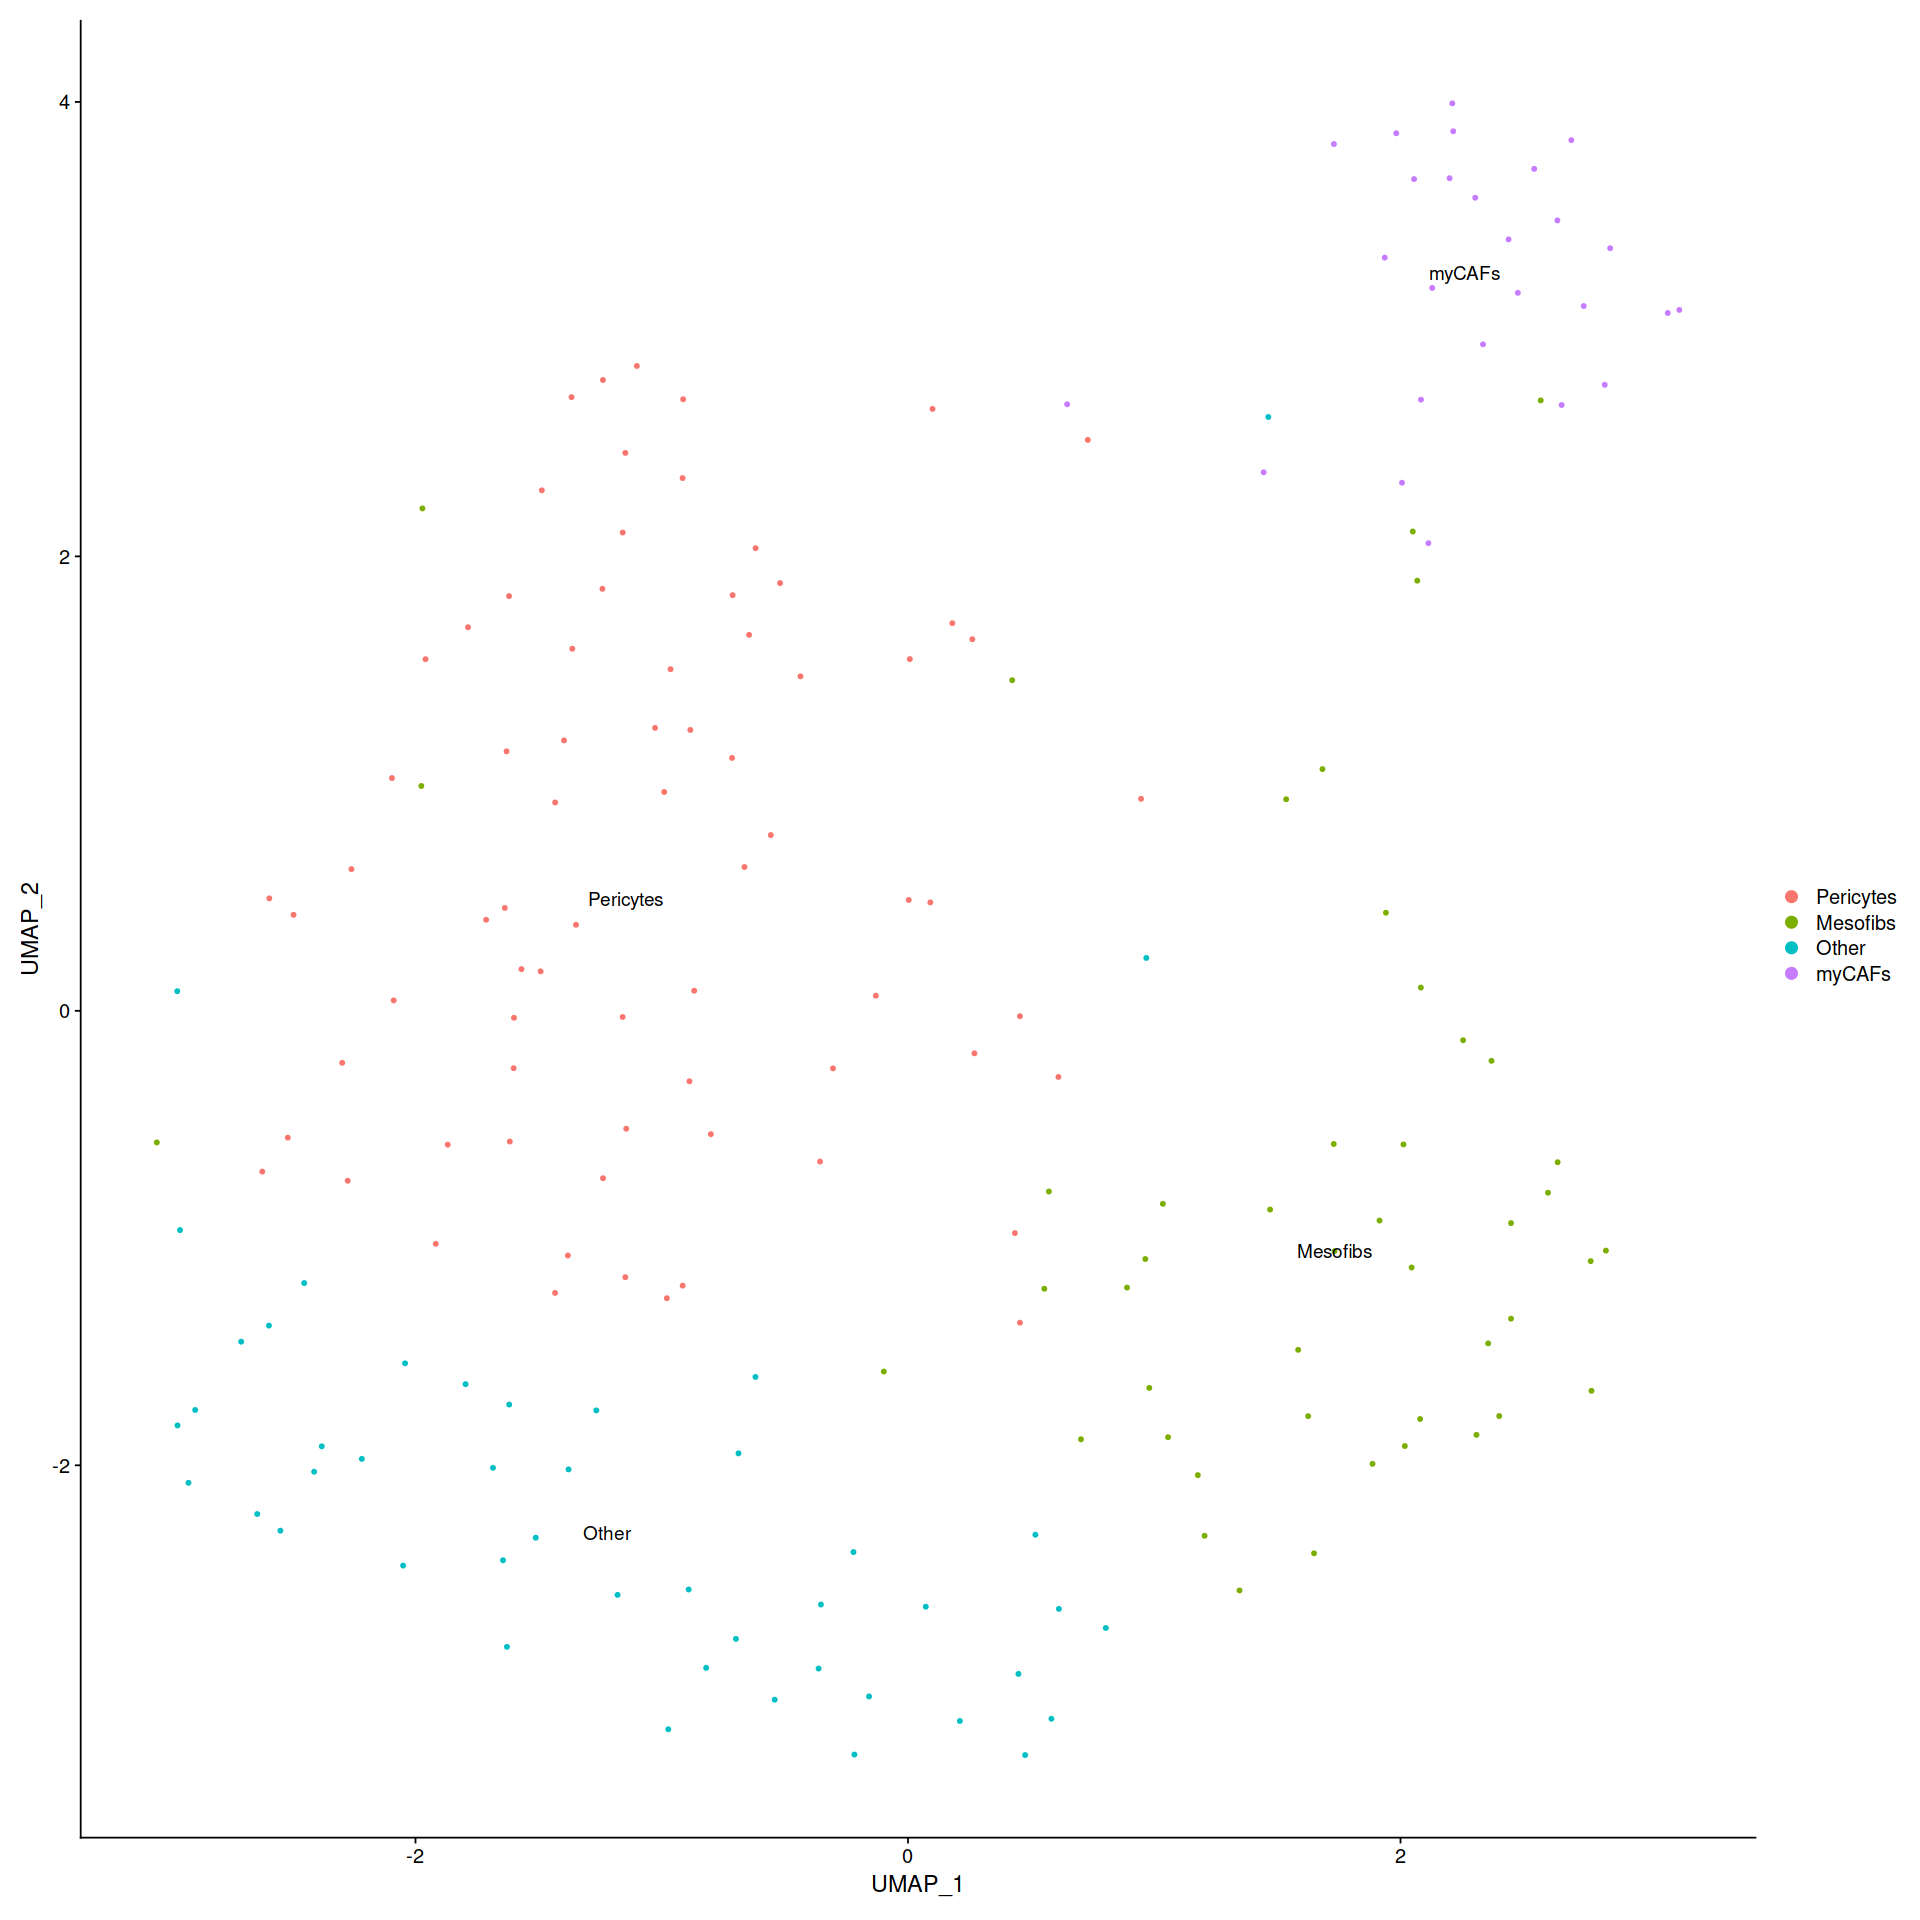

In [146]:
stromal_subtypes <- reclustering(stromal_subset, stromal)
DimPlot(stromal_subtypes, reduction="umap", label=TRUE)

new_idents <- Idents(stromal_subtypes)
seu_integrated$subtypes[names(new_idents)] <- as.character(new_idents)

table(seu_integrated$subtypes)


In [151]:
#check cell cluster identity per sample
table(Idents(seu_integrated), seu_integrated$orig.ident)

# Update the active identities to the new subtype labels stored in metadata
Idents(seu_integrated) <- seu_integrated$subtypes
table(Idents(seu_integrated), seu_integrated$orig.ident)

#save rds
saveRDS(seu_integrated, "/home/lythgo02/Documents/scRNAseq/annotated_scRNAseq.rds")

                       
                        GSM4816045 GSM4816046 GSM4816047
  Epithelial_Tumour            561        265        549
  Other                         62         73        175
  Endo                          49          4         72
  Bcell                         39         26          0
  myCAFs                        22          2          2
  Mesofibs                       4          3         40
  Pericytes                     21          1         52
  Macrophages_M1                 2         77          0
  Macrophages_M2                31        158         17
  Dendritic_cells                1         18          2
  Neutrophils                   53          6         20
  CD8_memory_T_cell             32         37          0
  CD8_cytotoxic_T_cell          67          5          5
  CD4_T_regulatory_cell          0         49          0
  NKcell                         0         46          0

                       
                        GSM4816045 GSM4816046 GSM4816047
  Epithelial_Tumour            561        265        549
  Other                         62         73        175
  Endo                          49          4         72
  Bcell                         39         26          0
  myCAFs                        22          2          2
  Mesofibs                       4          3         40
  Pericytes                     21          1         52
  Macrophages_M1                 2         77          0
  Macrophages_M2                31        158         17
  Dendritic_cells                1         18          2
  Neutrophils                   53          6         20
  CD8_memory_T_cell             32         37          0
  CD8_cytotoxic_T_cell          67          5          5
  CD4_T_regulatory_cell          0         49          0
  NKcell                         0         46          0

In [152]:

counts_matrix <- GetAssayData(seu_integrated, assay="RNA", slot="counts")
write.csv(as.matrix(counts_matrix), file="/home/lythgo02/Documents/scRNAseq/count_matrix.csv", row.names=TRUE)


In [ ]:
library(Seurat)
library(SeuratDisk)
library(dplyr)
library(scCATCH)

seu_integrated <- readRDS("/home/lythgo02/Documents/scRNAseq/clustered_scRNAseq.rds")



In [ ]:
Annotate cell types with Seurat  
 - Find markers that define clusters via differential expression.  
 - By default, it identifies positive and negative markers of a single cluster (specified in ident.1), compared to all other cells. 
 - FindAllMarkers() automates this process for all clusters, but you can also test groups of clusters vs. each other, or against all cells.

In [ ]:

# Identify cluster markers for all clusters
seu_markers <- FindAllMarkers(
  object = seu_integrated,
  only.pos=TRUE #return only the positive ones
)
#or for specific cluster comparisons
# find all markers distinguishing cluster 5 from clusters 0 and 3
#cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3))
#head(cluster5.markers, n = 5)

In [ ]:
# Optional: View top markers per cluster
seu_markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1)


Generate an expression heatmap for given cells and features 

In [ ]:
seu_markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1) %>%
    slice_head(n = 10) %>%
    ungroup() -> top10

p <- DoHeatmap(seu_integrated, features = top10$gene) + NoLegend()

ggplot2::ggsave(
  file.path(qc_plot_dir, "heatmap_top10_markers_res_1.2.png"),
  plot = p,
  width = 12,   # increase width (default ~7)
  height = 8,   # adjust height if needed
  dpi = 300
)

In [ ]:
library(readxl)
path <- "/home/lythgo02/Documents/scRNAseq/"
# Load the marker list from your uploaded Excel file
marker_table <- read_excel(paste0(path, "NatComms/mmc3_cellmarkers.xlsx"), skip=2) %>% as.data.frame()

# Create a named list: cell type → marker genes
marker_list <- split(marker_table$Metagene, marker_table$`Cell type`)

In [ ]:
unique(marker_list$cel)

In [ ]:

# Match clusters to best-fitting cell type
cluster_ids <- levels(seu_integrated)
cluster_annotations <- sapply(cluster_ids, function(cl) {
  cluster_genes <- seu_markers %>% filter(cluster == cl) %>% pull(gene)
  
  overlaps <- sapply(marker_list, function(markers) {
    length(intersect(cluster_genes, markers))
  })
  
  names(which.max(overlaps))
})

# Rename cluster identities
names(cluster_annotations) <- cluster_ids


In [ ]:
seu_integrated <- RenameIdents(seu_integrated, cluster_annotations)

In [ ]:
DimPlot(seu_integrated, reduction = "umap", label = TRUE, pt.size = 0.5) #+ NoLegend()


Working with a different dataset - preannotated from Fran Balkwill

In [26]:
library(Seurat)
library(Matrix)
library(dplyr)

# Set directory
data_dir <- "/run/user/1804238067/gvfs/sftp:host=clust1-sub-1,user=lythgo02/mnt/nas-data/fmlab/group_folders/lythgo02/Spatial/scRNAseq/GSE266577/"

#has to rename files to fit format reaquried by read10x
list.files(data_dir)



[1] "GSE266577_barcodes.txt.gz"        "GSE266577_counts_raw.mtx.gz"     
[3] "GSE266577_metadata.txt.gz"        "GSE266577_seurat_features.txt.gz"
[5] "s41467-024-54295-x.pdf"

In [ ]:
features <- read.delim(gzfile(paste0(data_dir,"GSE266577_seurat_features.txt.gz")), header = FALSE)
barcodes <- read.delim(gzfile(paste0(data_dir,"GSE266577_barcodes.txt.gz")), header = FALSE)
matrix <- readMM(gzfile(paste0(data_dir,"GSE266577_counts_raw.mtx.gz")))
 
metadata <- read.delim(gzfile(paste0(data_dir,"GSE266577_metadata.txt.gz")))



ERROR: Error in column_to_rownames(metadata, "cell_name"): could not find function "column_to_rownames"


In [ ]:

# Check that number of rows in the matrix match number of rows in features
nrow(matrix)
nrow(features)
 
colnames(matrix) <- barcodes$V1 # check that V1 contains barcodes
rownames(matrix) <- make.unique(features$V1) # check that V2 contains gene names (## only a V1 column? changed from V2 -> V1)
 
head(matrix)

metadata <- tibble::column_to_rownames(metadata, 'cell_name')

[1] 58037

[1] 58037

   [[ suppressing 34 column names ‘AAACCTGCAACGATGG-5’, ‘AAACCTGGTGAGGGTT-5’, ‘AAACCTGTCTGAGTGT-5’ ... ]]



6 x 137083 sparse Matrix of class "dgTMatrix"
                                                                             
DDX11L1   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
WASH7P    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
MIR6859-1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
MIR1302-2 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
FAM138A   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
OR4G4P    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
                
DDX11L1   ......
WASH7P    ......
MIR6859-1 ......
MIR1302-2 ......
FAM138A   ......
OR4G4P    ......

 .....suppressing 137049 columns in show(); maybe adjust 'options(max.print= *, width = *)'
 ..............................

In [31]:
scRNAseq <- CreateSeuratObject(counts = matrix,min.cells = 3, min.features = 200, meta.data = metadata)

In [35]:
table(scRNAseq@meta.data$cell_type)


           CD16- NK cells            CD16+ NK cells       Classical monocytes 
                     1328                       386                       546 
                      DC1                       DC2         Endothelial cells 
                      316                        59                       419 
         Epithelial cells               Fibroblasts                       ILC 
                    22741                     17908                      1121 
              Macrophages                Mast cells            Memory B cells 
                    23919                      1901                      5531 
        Mesothelial cells             Migratory DCs             Naive B cells 
                      484                      1059                      1749 
                 NK cells                       pDC              Plasma cells 
                     4091                       538                      2397 
       Regulatory T cells  Tcm/Naive helper T cells

In [38]:
# Define the chemo-naive sample IDs - currently mix of omentum, ovary and perineum)
chemo_naive_samples <- c(
  "S002", "S003", "S004", "S005", "S006", "S007", "S008", "S009",
  "S010", "S011", "S012", "S013", "S014", "S015", "S016", "S017",
  "S018", "S019", "S020", "S021", "S022", "S025", "S027", "S028",
  "S029", "S030", "S031", "S032"
)

# Filter Seurat object to those samples
scRNAseq_chemo_naive <- subset(
  scRNAseq,
  subset = publication_patient_code_final %in% chemo_naive_samples
)


##Alternative approach to identify cell types using scCATCH which queries CellMarker2.0

scCATCH uses a curated gene reference (geneinfo) from NCBI to match your gene symbols to known cell type markers.  
If your dataset uses outdated or inconsistent gene names (e.g. aliases, Ensembl IDs, or case mismatches), rev_gene() ensures compatibility.  
Loading geneingo loads a reference table of gene symbol metadata from NCBI, which is used by rev_gene() to clean and standardize your gene names.

In [ ]:
# Load built-in geneinfo for human
data("geneinfo", package = "scCATCH")

#also load cell markers for later step
data("cellmatch", package = "scCATCH")


In [ ]:
# Extract normalized RNA data from Seurat
expr_mat <- as.matrix(seu_integrated@assays$RNA@data)

# Revise gene symbols to match NCBI reference
expr_mat <- rev_gene(
  data = expr_mat,
  data_type = "data",       # "data" means gene expression matrix
  species = "Human",
  geneinfo = geneinfo       # built-in human geneinfo
)


In [ ]:
class(Idents(seu_integrated))

expr_mat

In [ ]:

# Create cluster vector
clusters <- Idents(seu_integrated)  # your 9 or finer clusters

# Create scCATCH object
scCATCH_results <- createscCATCH(
  data = expr_mat,
  cluster = as.character(clusters) 
)

data("cellmatch", package = "scCATCH")

scCATCH_results <- findmarkergene(
  object = scCATCH_results,
  species = "Human",
  tissue = "Ovary",
  marker=cellmatch
)

In [ ]:
scCATCH_results <- findcelltype(object = scCATCH_results)

In [ ]:
#check results
scCATCH_results@celltype

In [ ]:
library(SeuratDisk)
#Saves the integrated Seurat object to .h5Seurat.
#Converts it to .h5ad format for Python compatibility (Scanpy).
#converted file is automatically saved when you run convert
SaveH5Seurat(seu_integrated, filename = "/scRNAseq/comb_GSE158937.h5Seurat")
Convert("comb_GSE158937.h5Seurat", assay = "RNA", dest = "/scRNAseq/comb_GSE158937.h5ad")

Then quit and prepare spatial data 